In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/padhai-hindi-vowel-consonant-classification/sample_submission.csv
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/4390.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/283.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/2319.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/3383.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/4956.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/1609.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/3095.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/4847.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/1091.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/2758.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/5750.png
/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/5230.p

In [2]:
#importing required libraries
import os
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split

import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.optim as optim
import torch
import torch.nn as nn
import pandas as pd

device = torch.device('cuda:0')
data_path = {'train' : "/kaggle/input/padhai-hindi-vowel-consonant-classification/train/train/", 'test' : "/kaggle/input/padhai-hindi-vowel-consonant-classification/test/test/"}
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [3]:
#For converting the dataset to torchvision dataset format
class HindiVowelConsonantDataset(Dataset):
    
    def __init__(self, data_path, transform = None, train = True):
        self.train_img_path = data_path['train']
        self.test_img_path = data_path['test']
        self.train_img_files = os.listdir(self.train_img_path)
        self.test_img_files = os.listdir(self.test_img_path)
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return len(self.train_img_files)
    
    def __getitem__(self, indx):
            
        if self.train:  
            
            if indx >= len(self.train_img_files):
                raise Exception("Index should be less than {}".format(len(self.train_img_files)))
               
            image = Image.open(self.train_img_path + self.train_img_files[indx]).convert('RGB')
            labels = self.train_img_files[indx].split('_')
            V = int(labels[0][1])
            C = int(labels[1][1])
            label = {'Vowel' : V, 'Consonant' : C}

            if self.transform:
                image = self.transform(image)

            return image, label
        
        if self.train == False:
            image = Image.open(self.test_img_path + self.test_img_files[indx]).convert('RGB')
            if self.transform:
                image = self.transform(image)

            return image, self.test_img_files[indx]

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [5]:
data = HindiVowelConsonantDataset(data_path, transform = transform, train = True)

train_size = int(0.9 * len(data))
test_size = len(data) - train_size

train_data, validation_data = random_split(data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=False)

In [6]:
test_data = HindiVowelConsonantDataset(data_path, transform = transform, train = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
test_iter = iter(test_loader)
print(test_iter.next())

[tensor([[[[ 1.7180,  1.5125,  1.6153,  ...,  1.1529,  1.0673,  0.5707],
          [ 1.2557,  0.8104,  0.9988,  ..., -0.0287,  0.1939, -0.4739],
          [ 1.3755,  0.9646,  0.9474,  ...,  0.3652,  0.0056, -0.5253],
          ...,
          [-0.1657, -0.9020, -1.0390,  ..., -1.8097, -1.6555, -1.7412],
          [-0.1486, -0.9020, -1.0048,  ..., -1.6555, -1.6555, -1.8097],
          [-1.1075, -1.6384, -1.6042,  ..., -1.8782, -1.8953, -1.9295]],

         [[ 1.3256,  1.0105,  1.1331,  ...,  0.7479,  0.7129,  0.0126],
          [ 0.3803, -0.2325, -0.0749,  ..., -0.6176, -0.5476, -1.0028],
          [ 0.4328, -0.0399, -0.1275,  ..., -0.5126, -0.5301, -1.0553],
          ...,
          [-0.6001, -1.4230, -1.5105,  ..., -2.0357, -2.0007, -2.0007],
          [-0.5651, -1.4055, -1.4580,  ..., -2.0182, -2.0007, -2.0182],
          [-1.4755, -1.8081, -1.7906,  ..., -2.0357, -2.0182, -2.0007]],

         [[ 1.0714,  0.6879,  0.7054,  ...,  0.5659,  0.5136, -0.3404],
          [-0.2184, -0.8981, 

In [7]:
def plot_image(image):
  plt.imshow(np.transpose(image,(1,2,0)).squeeze())
  plt.show

torch.Size([32, 3, 64, 64])
tensor(0)
tensor(8)


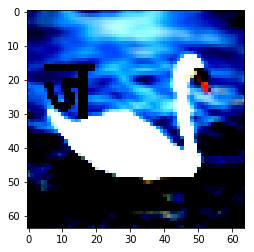

In [8]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
plot_image(images[0])
print(images.shape)
print(labels['Vowel'][0])
print(labels['Consonant'][0])

In [9]:

def modify_model(model):
#     for param in model.features.parameters():
#         param.require_grad = False

    num_in_features = model.classifier[6].in_features
    mod_classifier = list(model.classifier.children())[:-1]
    mod_classifier.extend([nn.Linear(num_in_features,10)])
    model.classifier = nn.Sequential(*mod_classifier)
    model = model.to(device)
    

In [10]:
vgg16_vowel = models.vgg16_bn()
vgg16_cons = models.vgg16_bn()
modify_model(vgg16_vowel)
modify_model(vgg16_cons)

# resnet50_vowel = models.resnet50()
# resnet50_cons = models.resnet50()
# fc_vowel = [resnet50_vowel.fc]
# fc_vowel.extend([
#            nn.Linear(1000,128),
#            nn.ReLU(inplace = True),
#            nn.Dropout(p=0.5, inplace=False),
#            nn.Linear(128,128),
#            nn.ReLU(inplace = True),
#            nn.Dropout(p=0.5, inplace=False),
#            nn.Linear(128,10),
#           ])
# resnet50_vowel.fc = nn.Sequential(*fc_vowel)

# fc_cons = [resnet50_cons.fc]
# fc_cons.extend([
#            nn.ReLU(inplace = True),
#            nn.Dropout(p=0.5, inplace=False),
#            nn.Linear(1000,128),
#            nn.ReLU(inplace = True),
#            nn.Dropout(p=0.5, inplace=False),
#            nn.Linear(128,128),
#            nn.ReLU(inplace = True),
#            nn.Dropout(p=0.5, inplace=False),
#            nn.Linear(128,10),
#           ])
# resnet50_cons.fc = nn.Sequential(*fc_cons)

In [11]:
# resnet50_vowel.to(device)
# resnet50_cons.to(device)

In [12]:
def train(model_vowel,model_cons,opt_vowel,opt_cons,loss_fn_vowel,loss_fn_cons,traindata,epoch =1):
    acc={}
    for e in range(epoch) :
        for i,data in enumerate(traindata,0):
            images,labels = data
            images = images.to(device)
            labels_vowel = labels['Vowel'].to(device)
            labels_cons = labels['Consonant'].to(device)
            
            out_vowel = model_vowel(images)
            loss_vowel = loss_fn_vowel(out_vowel,labels_vowel)
            out_cons = model_cons(images)
            loss_cons = loss_fn_cons(out_cons,labels_cons)
            
            opt_vowel.zero_grad()
            opt_cons.zero_grad()
            (loss_vowel+loss_cons).backward()
            opt_vowel.step()
            opt_cons.step()
        print(' epoch - %d'%(e))
        model_vowel.eval()
        model_cons.eval()
        acc[e] = eval(model_vowel,model_cons,validation_loader)
        print('-------------------------------------')
        model_vowel.train()
        model_cons.train()
        plt.plot(acc.values())

In [13]:
def eval(model_vowel,model_cons,in_data):
    total,vov_suc,cons_suc = 0,0,0
    for data in in_data:
        images,labels = data
        images = images.to(device)
        labels_vowel = labels['Vowel'].to(device)
        labels_cons = labels['Consonant'].to(device)
        
        out_vowel = model_vowel(images)
        val,index = torch.max(out_vowel.data,1)
        vov_suc+=(labels_vowel==index).sum().item()
        
        out_cons = model_cons(images)
        val,index = torch.max(out_cons.data,1)
        cons_suc+=(labels_cons==index).sum().item()
        
        total+=labels_vowel.size(0)
        
    acc_vowel = vov_suc/total*100
    acc_cons = cons_suc/total*100
        
    print('Vowel Accuracy = %d'%(acc_vowel))
    print('Consonant Accuracy = %d'%(acc_cons))
    return (acc_vowel+acc_cons)/2
        

        

 epoch - 0
Vowel Accuracy = 21
Consonant Accuracy = 10
-------------------------------------
 epoch - 1
Vowel Accuracy = 19
Consonant Accuracy = 11
-------------------------------------
 epoch - 2
Vowel Accuracy = 23
Consonant Accuracy = 17
-------------------------------------
 epoch - 3
Vowel Accuracy = 20
Consonant Accuracy = 25
-------------------------------------
 epoch - 4
Vowel Accuracy = 55
Consonant Accuracy = 19
-------------------------------------
 epoch - 5
Vowel Accuracy = 55
Consonant Accuracy = 27
-------------------------------------
 epoch - 6
Vowel Accuracy = 29
Consonant Accuracy = 22
-------------------------------------
 epoch - 7
Vowel Accuracy = 60
Consonant Accuracy = 33
-------------------------------------
 epoch - 8
Vowel Accuracy = 57
Consonant Accuracy = 30
-------------------------------------
 epoch - 9
Vowel Accuracy = 64
Consonant Accuracy = 57
-------------------------------------
 epoch - 10
Vowel Accuracy = 18
Consonant Accuracy = 52
--------------

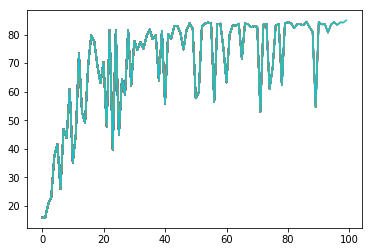

In [14]:
torch.manual_seed(0)
opt_vowel = optim.SGD(vgg16_vowel.parameters(),lr=0.01)
opt_cons = optim.SGD(vgg16_cons.parameters(),lr=0.01)
loss_fn_vowel = nn.CrossEntropyLoss()
loss_fn_cons = nn.CrossEntropyLoss()
train(vgg16_vowel,vgg16_cons,opt_vowel,opt_cons,loss_fn_vowel,loss_fn_cons,train_loader,epoch=100)



In [15]:

image_id = []
image_class = []


for data in test_loader:
    image,label =data
    image = image.to(device)
    vgg16_vowel.eval()
    out_v = vgg16_vowel(image)
    val,vow_index = torch.max(out_v,1)

    vgg16_cons.eval()
    out_c = vgg16_cons(image)
    val,con_index = torch.max(out_c.cpu(),1)
    
    for lab in label:
        image_id.append(lab)
            
    for i,j in zip(vow_index,con_index):
            image_class.append('V'+str(i.item())+'_'+'C'+str(j.item()))
                               
df = pd.DataFrame([image_id,image_class])
df = df.transpose()
df.columns = ['ImageID','Class']

In [16]:
df.head()

,ImageID,Class
0,637.png,V0_C6
1,7990.png,V7_C9
2,8437.png,V8_C3
3,8312.png,V8_C3
4,8948.png,V7_C9


In [17]:
df.to_csv('out.csv',index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 